In [ ]:
import os
import re
import random
import math
import numpy as np
import pandas as pd
from matplotlib.pyplot import plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tqdm import tqdm
import gensim

from utils import build_corpus, lexical_sub
from models import Transformer, generate_masks
from loss import loss_function, LearningRateScheduler

2025-03-12 23:55:40.771618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 23:55:40.778186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 23:55:40.786091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 23:55:40.788451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 23:55:40.794876: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1741791341.942147   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741791341.970191   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741791341.971880   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# load data
# file_pth = os.environ.get("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData.csv'
file_pth = os.environ.get("HOME") + '/Desktop/Quest06/data/ChatbotData.csv'
df = pd.read_csv(file_pth)

df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
df = df.drop(columns=["label"]) # 'label' 열 제거
df = df.drop_duplicates() # 중복 데이터 제거

In [5]:
print('the number of samples: ', len(df))

the number of samples:  11750


#### 데이터 전처리 & 토큰화

- 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.  
- 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.

In [6]:
df = df.sample(frac=1).reset_index(drop=True) # train / test split 전에 무작위 shuffle
df.head()

,Q,A
0,짜증난다!!,심호흡해보세요.
1,어젯밤 집 앞에서 잠깐 만났어.,마음이 복잡하겠어요.
2,내 이상형이 아닌데 그 남자를 왜 이렇게 좋아할까.,이상형은 이상형일 뿐이니까요.
3,음악 들으면서 잊으려고,음악이 도움이 되길 바랍니다.
4,시험 보지 말까?,응시는 해야죠.


In [7]:
# train / test split
test_len = len(df) // 10

que_corpus_train = df["Q"][:-test_len]
que_corpus_test = df["Q"][-test_len:]

ans_corpus_train = df["A"][:-test_len]
ans_corpus_test = df["A"][-test_len:]

In [8]:
que_corpus_train = build_corpus(que_corpus_train)
que_corpus_test = build_corpus(que_corpus_test, is_train=False) # test data에는 전처리만 진행

ans_corpus_train = build_corpus(ans_corpus_train)
ans_corpus_test = build_corpus(ans_corpus_test, is_train=False)

print(len(que_corpus_train))
print(len(ans_corpus_train))
print(len(que_corpus_test))
print(len(ans_corpus_test))

10575
10575
1175
1175


#### Augmentation

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [9]:
model = gensim.models.Word2Vec.load(os.environ.get("HOME") + '/Desktop/Quest06/data/word2vec_ko.model')

In [10]:
model.wv.most_similar("사과")

[('사죄', 0.7787620425224304),
 ('항의', 0.6764886379241943),
 ('해명', 0.6568262577056885),
 ('고소', 0.6460005640983582),
 ('선처', 0.6412018537521362),
 ('감사', 0.6356635093688965),
 ('죄송', 0.6350489258766174),
 ('조롱', 0.6300912499427795),
 ('질타', 0.6276609301567078),
 ('협박', 0.6233218908309937)]

In [12]:
src = '더 격렬 하 게 아무 것 도 안 하 고 싶 다 .'

print(" ".join(lexical_sub(src, model.wv, ratio=0.3)))

너무   격 렬   하   게   아 무치   것   도   앞   하   는데   싶   다   .


In [13]:
new_que_corpus_train = []

for old_src in que_corpus_train:
    new_src = lexical_sub(old_src, model.wv, ratio=0.3)
    new_que_corpus_train.append(new_src)

In [ ]:
print([" ".join(sample) for sample in que_corpus_train[:10]])
print([" ".join(sample) for sample in new_que_corpus_train[:10]])

['짜증 난다 !"> !', '문득 방 앞 의 잠깐 만났 어서 "', '내 만 형 이 아닌데 그 남자 를 과연 이렇게 좋 아서 할까 .', '음악 들으면서 잊 으려고', '시험 보 지 말 까 ?', '마음 이 방식 는 건가 같 아', '택배 이 안 와', '천사 같 은 남자 친구 가 떠나갔 어서 마음 은 굉장히 아픕니다 .', '전 여친 남자 생겨났 나 봐', '사랑 했 다']
['짜증 난다 ! !', '어젯밤 집 앞 에서 잠깐 만났 어 .', '내 이상 형 이 아닌데 그 남자 를 왜 이렇게 좋 아 할까 .', '음악 들으면서 잊 으려고', '시험 보 지 말 까 ?', '마음 이 식 은 거 같 아', '택배 가 안 와', '천사 같 은 여자 친구 가 떠나갔 어 마음 이 너무 아픕니다 .', '전 여친 남자 생겼 나 봐', '이별 했 다']


In [15]:
augmented_que_train = que_corpus_train + new_que_corpus_train + que_corpus_train
print(len(augmented_que_train))

31725


In [16]:
new_ans_corpus_train = []

for old_src in ans_corpus_train:
    new_src = lexical_sub(old_src, model.wv, ratio=0.3)
    new_ans_corpus_train.append(new_src)

In [17]:
augmented_ans_train = ans_corpus_train + ans_corpus_train + new_ans_corpus_train 
print(len(augmented_ans_train))

31725


#### 데이터 벡터화

In [18]:
# <start>와 <end> 토큰을 ans_corpus에 추가
augmented_ans_train = [['<start>'] + sentence + ['<end>'] for sentence in augmented_ans_train]

In [ ]:
# que_corpus와 ans_corpus 결합하여 단어 사전 생성
combined_corpus = augmented_que_train + augmented_ans_train

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(combined_corpus)

# 각 문장을 정수 시퀀스로 변환
enc_train = tokenizer.texts_to_sequences(augmented_que_train)
dec_train = tokenizer.texts_to_sequences(augmented_ans_train)

In [23]:
# 패딩 추가
max_len = 40

enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, 
                                                          maxlen=max_len,
                                                         padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, 
                                                          maxlen=max_len,
                                                         padding='post')

print(enc_train.shape)
print(dec_train.shape)

(31725, 40)
(31725, 40)


In [24]:
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_train, dec_train, test_size=0.1)

In [25]:
BATCH_SIZE = 256

train_data = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).batch(batch_size=BATCH_SIZE)

print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(28552, 40) (28552, 40)
(3173, 40) (3173, 40)


I0000 00:00:1741791851.925067   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741791851.926781   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741791851.928348   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741791852.024247   17810 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

#### 모델 학습

In [105]:
D_MODEL = 256
VOCAB_SIZE = len(tokenizer.word_index)

transformer = Transformer(
    n_layers=3,
    d_model=D_MODEL,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=max_len,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

In [106]:
learning_rate = LearningRateScheduler(D_MODEL, warmup_steps=4000)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     epsilon=1e-9)

In [107]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input : end 토큰 제외
    gold = tgt[:, 1:]     # Decoder의 output : start 토큰 제외

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [108]:
@tf.function()
def eval_step(src, tgt, model):
    tgt_in = tgt[:, :-1]  # Decoder의 input : end 토큰 제외
    gold = tgt[:, 1:]     # Decoder의 output : start 토큰 제외

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    # 그래디언트를 계산하지 않음
    predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

    # 손실 계산
    loss = loss_function(gold, predictions)

    return loss, enc_attns, dec_attns, dec_enc_attns

In [109]:
EPOCHS = 25

import matplotlib.pyplot as plt

train_losses = []  # 학습 손실을 저장할 리스트
eval_losses = []   # 평가 손실을 저장할 리스트

for epoch in range(EPOCHS):
    total_loss = 0
    total_eval_loss = 0  # 평가 손실을 저장할 변수

    # 훈련 데이터에 대해 학습
    dataset_count = tf.data.experimental.cardinality(train_data).numpy()
    tqdm_bar = tqdm(enumerate(train_data), total=dataset_count)
    
    for batch, (enc_inputs, dec_inputs) in tqdm_bar:
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_inputs, dec_inputs, transformer, optimizer)

        total_loss += batch_loss

        tqdm_bar.set_description_str(f'Epoch {epoch + 1}')
        tqdm_bar.set_postfix_str(f'Loss {total_loss.numpy() / (batch + 1):.4f}')
    
    train_losses.append(total_loss.numpy() / (batch + 1))  # 학습 손실 기록
    
    # 평가 단계
    eval_dataset_count = tf.data.experimental.cardinality(val_data).numpy()
    eval_tqdm_bar = tqdm(enumerate(val_data), total=eval_dataset_count)

    for batch, (enc_inputs, dec_inputs) in eval_tqdm_bar:
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            eval_step(enc_inputs, dec_inputs, transformer)

        total_eval_loss += batch_loss

        eval_tqdm_bar.set_description_str(f'Epoch {epoch + 1} Validation')
        eval_tqdm_bar.set_postfix_str(f'Val Loss {total_eval_loss.numpy() / (batch + 1):.4f}')

    eval_losses.append(total_eval_loss.numpy() / (batch + 1))  # 평가 손실 기록

    print(f"Epoch {epoch + 1} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {eval_losses[-1]:.4f}")


Epoch 1 Validation: 100%|██████████| 13/13 [00:00<00:00, 13.67it/s, Val Loss 5.6670]


Epoch 1 - Training Loss: 7.7673, Validation Loss: 5.6670


Epoch 2 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.10it/s, Val Loss 4.8290]


Epoch 2 - Training Loss: 5.1614, Validation Loss: 4.8290


Epoch 3 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.83it/s, Val Loss 4.2193]


Epoch 3 - Training Loss: 4.5382, Validation Loss: 4.2193


Epoch 4 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.05it/s, Val Loss 3.6420]


Epoch 4 - Training Loss: 3.8757, Validation Loss: 3.6420


Epoch 5 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.97it/s, Val Loss 3.2266]


Epoch 5 - Training Loss: 3.3348, Validation Loss: 3.2266


Epoch 6 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.07it/s, Val Loss 2.8240]


Epoch 6 - Training Loss: 2.8157, Validation Loss: 2.8240


Epoch 7 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.91it/s, Val Loss 2.4271]


Epoch 7 - Training Loss: 2.2313, Validation Loss: 2.4271


Epoch 8 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.98it/s, Val Loss 2.1193]


Epoch 8 - Training Loss: 1.6657, Validation Loss: 2.1193


Epoch 9 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.97it/s, Val Loss 2.0303]


Epoch 9 - Training Loss: 1.2727, Validation Loss: 2.0303


Epoch 10 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.00it/s, Val Loss 1.8217]


Epoch 10 - Training Loss: 1.0332, Validation Loss: 1.8217


Epoch 11 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.16it/s, Val Loss 1.7073]


Epoch 11 - Training Loss: 0.8211, Validation Loss: 1.7073


Epoch 12 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.94it/s, Val Loss 1.7269]


Epoch 12 - Training Loss: 0.6921, Validation Loss: 1.7269


Epoch 13 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.85it/s, Val Loss 1.6997]


Epoch 13 - Training Loss: 0.6104, Validation Loss: 1.6997


Epoch 14 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.98it/s, Val Loss 1.6777]


Epoch 14 - Training Loss: 0.5442, Validation Loss: 1.6777


Epoch 15 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.85it/s, Val Loss 1.6266]


Epoch 15 - Training Loss: 0.4967, Validation Loss: 1.6266


Epoch 16 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.98it/s, Val Loss 1.6233]


Epoch 16 - Training Loss: 0.4594, Validation Loss: 1.6233


Epoch 17 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.91it/s, Val Loss 1.6245]


Epoch 17 - Training Loss: 0.4378, Validation Loss: 1.6245


Epoch 18 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.10it/s, Val Loss 1.6630]


Epoch 18 - Training Loss: 0.4219, Validation Loss: 1.6630


Epoch 19 Validation: 100%|██████████| 13/13 [00:00<00:00, 39.02it/s, Val Loss 1.6473]


Epoch 19 - Training Loss: 0.4031, Validation Loss: 1.6473


Epoch 20 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.96it/s, Val Loss 1.6130]


Epoch 20 - Training Loss: 0.3865, Validation Loss: 1.6130


Epoch 21 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.88it/s, Val Loss 1.5739]


Epoch 21 - Training Loss: 0.3754, Validation Loss: 1.5739


Epoch 22 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.97it/s, Val Loss 1.5832]


Epoch 22 - Training Loss: 0.3632, Validation Loss: 1.5832


Epoch 23 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.90it/s, Val Loss 1.5885]


Epoch 23 - Training Loss: 0.3632, Validation Loss: 1.5885


Epoch 24 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.88it/s, Val Loss 1.5898]


Epoch 24 - Training Loss: 0.3621, Validation Loss: 1.5898


Epoch 25 Validation: 100%|██████████| 13/13 [00:00<00:00, 38.84it/s, Val Loss 1.5814]

Epoch 25 - Training Loss: 0.3515, Validation Loss: 1.5814


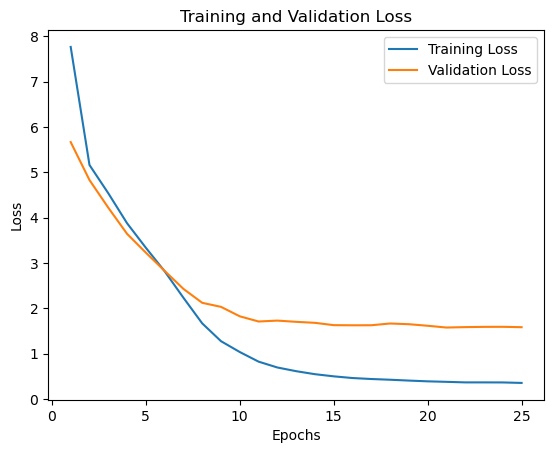

In [114]:
# training / validation loss 시각화
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), eval_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

#### 답변 생성하기

In [115]:
BOS_ID = 2
EOS_ID = 3

def translate(tokens, model, tokenizer):
    # 입력 문장을 패딩
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                                  maxlen=max_len,
                                                                  padding='post')

    ids = []
    output = tf.expand_dims([BOS_ID], 0)  # 시작 토큰 추가

    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                     output,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if predicted_id == EOS_ID:  # 종료 토큰이면 중단
            return tokenizer.sequences_to_texts([ids])[0]

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    return tokenizer.sequences_to_texts([ids])[0]

In [116]:
def generate_answers(sample_questions, model, tokenizer):
    responses = []
    
    for question in sample_questions:
        # 입력 문장을 정수 인덱스 시퀀스로 변환
        tokens = tokenizer.texts_to_sequences([question])[0]

        # 번역(답변 생성)
        response = translate(tokens, model, tokenizer)

        # 결과 저장
        responses.append(response)
    
    return responses

In [118]:
# 예문
sample_questions = ["지루하다, 놀러가고 싶어.",
                    "간만에 여자친구랑 데이트 하기로 했어.",
                    "집에 있는다는 소리야.",
                    "오늘 일찍 일어났더니 피곤하다.",
                    "썸을 오래 탔는데 사귀어도 괜찮은 사람일까?",
                    "이별에도 준비가 필요한 거겠죠?",
                    "뒤에서 얘기하면 내가 못 들을 줄 알았나봐?"]

answers = generate_answers(sample_questions, transformer, tokenizer)

for question, answer in zip(sample_questions, answers):
    print(f"질문: {question}")
    print(f"답변: {answer}\n")

질문: 지루하다, 놀러가고 싶어.
답변: 네

질문: 간만에 여자친구랑 데이트 하기로 했어.
답변: 힘 이 크 죠 .

질문: 집에 있는다는 소리야.
답변: 네

질문: 오늘 일찍 일어났더니 피곤하다.
답변: 오늘 어려서 주무세요 "

질문: 썸을 오래 탔는데 사귀어도 괜찮은 사람일까?
답변: 합격 단기간 에 는 면역 이 중요 노력 하 죠 .

질문: 이별에도 준비가 필요한 거겠죠?
답변: 네

질문: 뒤에서 얘기하면 내가 못 들을 줄 알았나봐?
답변: 좀 기다리 고 있 어 가 는 것 같 아요 .



#### BLEU score 평가하기

In [119]:
def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, max_len):
    src_tokens = tokenizer.texts_to_sequences([src_sentence])[0]
    tgt_tokens = tokenizer.texts_to_sequences([tgt_sentence])[0]

    # 길이가 max_len을 초과하면 평가하지 않음
    if len(src_tokens) > max_len: 
        return None
    if len(tgt_tokens) > max_len: 
        return None
    
    # 모델을 사용하여 번역 생성
    candidate = translate(src_tokens, model, tokenizer)

    # BLEU score 계산
    score = sentence_bleu(tgt_sentence, candidate, smoothing_function=SmoothingFunction().method1)

    return score

In [120]:
score = eval_bleu_single(transformer,
                         "비싼 명품 이제 그만 사야겠어",
                         "남의 눈을 위한 거라면 필요 없어요.",
                         tokenizer,
                         max_len)
print(score)

0.012219667481477889


In [121]:
def eval_bleu(model, src_sentences, tgt_sentence, tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in range(sample_size):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], tokenizer, verbose)
        if not score: 
            continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [122]:
eval_bleu(transformer, que_corpus_test, ans_corpus_test, tokenizer, verbose=False)

Num of Sample: 1175
Total Score: 0.0019674580706813614


#### 회고

- 기존 lexical_sub 함수의 문제점?  
    - 모든 토큰이 유사어로 바뀌다보니, 원래 문장과 의미도 상당히 다르고 문법적으로도 어색한 문장이 나오면서 원래에 비해 훼손된 문장을 생성하는 경우가 많았다.
    - 예를 들면, '사과'의 경우 '사죄'가 가장 유사한 단어이지만, 문맥상 '바나나', '과일' 등으로 대체되는 것이 합리적인 선택인 경우도 있다. 
    - 따라서 일부 단어만 랜덤하게 바꾸는 방식으로 로직을 변경하였다.

#### 총평

- 납득 가능한 답변을 생성하는 경우도 있었지만, 전반적으론 답변 생성의 품질이나 variation이 좋은 편은 아니었다. 그리고 bleu score가 매우 낮게 나왔는데, 이는 앞으로 개선해야 할 부분이다.  